This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [13]:
!pip install keras



  Using cached https://files.pythonhosted.org/packages/68/12/4cabc5c01451eb3b413d19ea151f36e33026fc0efb932bf51bcaf54acbf5/Keras-2.2.0-py2.py3-none-any.whl


In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Conv2D, Conv2DTranspose, merge, concatenate

In [3]:
%matplotlib inline
import importlib
# import utils2; importlib.reload(utils2)
# from utils2 import *

In [4]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import keras.backend as K

In [3]:
limit_mem()

# Tiramisu / Camvid

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. It was designed as a state-of-the-art approach to semantic image segmentation.

We're going to use the same dataset they did, CamVid.

CamVid is a dataset of images from a video. It has ~ 600 images, so it's quite small, and given that it is from a video the information content of the dataset is small. 

We're going to train this Tiramisu network from scratch to segment the CamVid dataset. This seems extremely ambitious!

## Setup

Modify the following to point to the appropriate paths on your machine

In [ ]:
# data_shape=224*224
# train_data, train_label = load_data("train")
# print((train_label).shape)
# train_label = np.reshape(train_label,(386,data_shape,1))

# test_data, test_label = load_data("test")
# test_label = np.reshape(test_label,(110,data_shape,1))

# val_data, val_label = load_data("val")
# val_label = np.reshape(val_label,(56,data_shape,1)

In [5]:
train_data = np.load('./data/train_data.npy')
print(train_data.shape)
#train_data = train_data.reshape((367, 224, 224, 3))
train_data = train_data.reshape((442, 224, 224, 3))
#train_label =  np.load('./data/train_label.npy')#[:,:,:-1]
train_label =  np.load('./data/train_label.npy')#[:,:,:-1]


# test_data = np.load('./data/test_data.npy')
test_data = np.load('./data/test_data.npy')
# test_data = test_data.reshape((233, 224, 224, 3))
test_data = test_data.reshape((110, 224, 224, 3))


# test_label = np.load('./data/test_label.npy')#[:,:,:-1]
test_label = np.load('./data/test_label.npy')#[:,:,:-1]

(442, 3, 224, 224)


In [73]:
# train_label[0].flatten().shape
train_label[0].shape

(50176, 1)

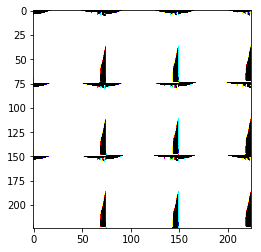

In [71]:
plt.imshow(train_data[0]);
# plt.imshow(train_label[0].flatten().reshape(224,224));

The images in CamVid come with labels defining the segments of the input image. We're going to load both the images and the labels.

Helper function to resize images.

Normalize pixel values.

Save array for easier use.

Standardize

## Preprocessing

### Generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

As an example, here's a crop of the first image.

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

We're going to map each unique pixel color to an integer so we can classify w/ our NN. (Think how a fill-in-the color image looks)

We'll include an integer for erroneous pixel values.

Now we'll create integer-mapped labels for all our colored images.

Set erroneous pixels to zero.

Here is an example of how the segmented image looks.

### Test set

Next we load test set, set training/test images and labels.

In [6]:
rnd_trn = len(train_label)
rnd_test = len(test_label)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [7]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
# def concat(xs): return merge(xs, mode='concat', concat_axis=-1)
def concat(xs): return concatenate(xs,axis=-1)

In [8]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [9]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        c=Conv2D(x, kernel_size=(1, 1), padding='same',
                                  kernel_initializer="he_uniform")
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [10]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [11]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [12]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [13]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
#         x = x+skips[i]
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [14]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [17]:
#USE THIS FOR SOFTMAX ACTIVATION
# def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
#     growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
#     if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
#         nb_layers = list(nb_layers_per_block)
#     else: nb_layers = [nb_layers_per_block] * nb_dense_block

#     x = conv(img_input, nb_filter, 3, wd, 0)
#     skips,added = down_path(x, nb_layers, growth_rate, p, wd)
#     x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
#     x = conv(x, nb_classes, 1, wd, 0)
#     _,r,c,f = x.get_shape().as_list()
#     x = Reshape((-1, nb_classes))(x)
#     return Activation('softmax')(x)

In [15]:
#MODEL FOR SIGMOID ACTIVATION
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    print(x.shape)
    print(x.get_shape().as_list())
    return Activation('sigmoid')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [55]:
limit_mem()

In [16]:
input_shape = (224,224,3)

In [17]:
img_input = keras.Input(shape=input_shape)

In [18]:
x = create_tiramisu(1, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning

(?, ?, 1)
[None, None, 1]


/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
model3 = keras.Model(img_input, x)

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return iou_coef(y_true, y_pred)

In [20]:
# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])
# USING BINARY CROSSENTROPY FOR OUR TWO CLASS LUNG SEGMENTATION
#ACCURACY CURVE
model3.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

# USE THIS TO CALCULATE IOU CURVE
# model3.compile(loss='binary_crossentropy', 
#              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["iou_coef_loss"])

In [21]:
#model3.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [22]:
K.set_value(model3.optimizer.lr, 1e-3) #try lr of 1e-2, 1e-4. no improvement with 1e-2, smoother and improved iou with 1e-4
batch_size = 5 #try with batch_size=10,20,30. 10 gives no improvement
nb_epoch=400 #try with more epochs. but overfits with 800. Training 400 epochs took 2 hrs

In [23]:
# model.fit_generator(gen, rnd_trn, 100, verbose=2, 
#                     validation_data=gen_test, nb_val_samples=rnd_test)
# model.fit_generator(train_data, rnd_trn, 100, verbose=2, 
#                     validation_data=gen_test, nb_val_samples=rnd_test)
history=model3.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch,verbose=2, validation_data=(test_data, test_label), shuffle=True)

Train on 442 samples, validate on 110 samples
Epoch 1/400
 - 21s - loss: 3.6352 - acc: 0.7463 - val_loss: 2.7970 - val_acc: 0.8329
Epoch 2/400
 - 15s - loss: 2.2524 - acc: 0.8452 - val_loss: 2.2340 - val_acc: 0.8630
Epoch 3/400
 - 15s - loss: 2.0253 - acc: 0.8567 - val_loss: 2.0777 - val_acc: 0.8736
Epoch 4/400
 - 15s - loss: 1.8032 - acc: 0.8696 - val_loss: 2.0308 - val_acc: 0.8769
Epoch 5/400
 - 15s - loss: 1.7137 - acc: 0.8775 - val_loss: 2.2848 - val_acc: 0.8314
Epoch 6/400
 - 15s - loss: 1.5795 - acc: 0.8814 - val_loss: 1.7386 - val_acc: 0.8601
Epoch 7/400
 - 15s - loss: 1.5277 - acc: 0.8859 - val_loss: 1.4798 - val_acc: 0.8791
Epoch 8/400
 - 15s - loss: 1.4735 - acc: 0.8887 - val_loss: 1.3572 - val_acc: 0.8966
Epoch 9/400
 - 15s - loss: 1.4205 - acc: 0.8899 - val_loss: 1.3262 - val_acc: 0.8630
Epoch 10/400
 - 15s - loss: 1.3280 - acc: 0.8944 - val_loss: 1.3774 - val_acc: 0.8946
Epoch 11/400
 - 15s - loss: 1.2858 - acc: 0.8960 - val_loss: 1.2323 - val_acc: 0.8841
Epoch 12/400
 - 1

Epoch 96/400
 - 15s - loss: 0.3689 - acc: 0.9502 - val_loss: 0.7733 - val_acc: 0.9046
Epoch 97/400
 - 15s - loss: 0.3863 - acc: 0.9492 - val_loss: 0.4092 - val_acc: 0.9501
Epoch 98/400
 - 15s - loss: 0.3536 - acc: 0.9520 - val_loss: 0.4055 - val_acc: 0.9490
Epoch 99/400
 - 15s - loss: 0.3719 - acc: 0.9503 - val_loss: 0.4692 - val_acc: 0.9338
Epoch 100/400
 - 15s - loss: 0.3601 - acc: 0.9508 - val_loss: 0.4063 - val_acc: 0.9498
Epoch 101/400
 - 15s - loss: 0.3570 - acc: 0.9511 - val_loss: 0.6105 - val_acc: 0.9302
Epoch 102/400
 - 15s - loss: 0.3497 - acc: 0.9519 - val_loss: 0.4321 - val_acc: 0.9449
Epoch 103/400
 - 15s - loss: 0.3481 - acc: 0.9519 - val_loss: 0.3742 - val_acc: 0.9498
Epoch 104/400
 - 15s - loss: 0.3515 - acc: 0.9511 - val_loss: 0.5153 - val_acc: 0.9269
Epoch 105/400
 - 15s - loss: 0.3488 - acc: 0.9519 - val_loss: 0.6426 - val_acc: 0.9178
Epoch 106/400
 - 15s - loss: 0.3511 - acc: 0.9512 - val_loss: 0.3818 - val_acc: 0.9402
Epoch 107/400
 - 15s - loss: 0.3274 - acc: 0.95

Epoch 191/400
 - 16s - loss: 0.1894 - acc: 0.9690 - val_loss: 0.3369 - val_acc: 0.9489
Epoch 192/400
 - 16s - loss: 0.2011 - acc: 0.9667 - val_loss: 0.3337 - val_acc: 0.9414
Epoch 193/400
 - 16s - loss: 0.1926 - acc: 0.9682 - val_loss: 0.3291 - val_acc: 0.9491
Epoch 194/400
 - 16s - loss: 0.1995 - acc: 0.9672 - val_loss: 0.2851 - val_acc: 0.9548
Epoch 195/400
 - 17s - loss: 0.1861 - acc: 0.9692 - val_loss: 0.6766 - val_acc: 0.8997
Epoch 196/400
 - 16s - loss: 0.1898 - acc: 0.9690 - val_loss: 0.2020 - val_acc: 0.9629
Epoch 197/400
 - 17s - loss: 0.1920 - acc: 0.9686 - val_loss: 0.2390 - val_acc: 0.9599
Epoch 198/400
 - 17s - loss: 0.1892 - acc: 0.9686 - val_loss: 0.2411 - val_acc: 0.9574
Epoch 199/400
 - 16s - loss: 0.1821 - acc: 0.9699 - val_loss: 0.2701 - val_acc: 0.9474
Epoch 200/400
 - 16s - loss: 0.1884 - acc: 0.9687 - val_loss: 0.2629 - val_acc: 0.9582
Epoch 201/400
 - 16s - loss: 0.1824 - acc: 0.9696 - val_loss: 0.3586 - val_acc: 0.9388
Epoch 202/400
 - 16s - loss: 0.1863 - acc: 

Epoch 286/400
 - 15s - loss: 0.1249 - acc: 0.9786 - val_loss: 0.1930 - val_acc: 0.9669
Epoch 287/400
 - 15s - loss: 0.1274 - acc: 0.9781 - val_loss: 0.1641 - val_acc: 0.9706
Epoch 288/400
 - 15s - loss: 0.1244 - acc: 0.9789 - val_loss: 0.1872 - val_acc: 0.9629
Epoch 289/400
 - 15s - loss: 0.1276 - acc: 0.9783 - val_loss: 0.1941 - val_acc: 0.9674
Epoch 290/400
 - 15s - loss: 0.1221 - acc: 0.9793 - val_loss: 0.2363 - val_acc: 0.9648
Epoch 291/400
 - 15s - loss: 0.1258 - acc: 0.9788 - val_loss: 0.1725 - val_acc: 0.9698
Epoch 292/400
 - 15s - loss: 0.1250 - acc: 0.9786 - val_loss: 0.1689 - val_acc: 0.9707
Epoch 293/400
 - 15s - loss: 0.1166 - acc: 0.9806 - val_loss: 0.1890 - val_acc: 0.9662
Epoch 294/400
 - 15s - loss: 0.1255 - acc: 0.9784 - val_loss: 0.2458 - val_acc: 0.9545
Epoch 295/400
 - 15s - loss: 0.1257 - acc: 0.9784 - val_loss: 0.1648 - val_acc: 0.9716
Epoch 296/400
 - 15s - loss: 0.1219 - acc: 0.9792 - val_loss: 0.1879 - val_acc: 0.9673
Epoch 297/400
 - 15s - loss: 0.1189 - acc: 

Epoch 381/400
 - 15s - loss: 0.0924 - acc: 0.9845 - val_loss: 0.1663 - val_acc: 0.9688
Epoch 382/400
 - 15s - loss: 0.0949 - acc: 0.9837 - val_loss: 0.1758 - val_acc: 0.9669
Epoch 383/400
 - 15s - loss: 0.0942 - acc: 0.9841 - val_loss: 0.1528 - val_acc: 0.9742
Epoch 384/400
 - 15s - loss: 0.0919 - acc: 0.9845 - val_loss: 0.1943 - val_acc: 0.9608
Epoch 385/400
 - 15s - loss: 0.0921 - acc: 0.9847 - val_loss: 0.1557 - val_acc: 0.9737
Epoch 386/400
 - 15s - loss: 0.0923 - acc: 0.9846 - val_loss: 0.1648 - val_acc: 0.9701
Epoch 387/400
 - 15s - loss: 0.0896 - acc: 0.9854 - val_loss: 0.1663 - val_acc: 0.9691
Epoch 388/400
 - 15s - loss: 0.0892 - acc: 0.9853 - val_loss: 0.1604 - val_acc: 0.9727
Epoch 389/400
 - 15s - loss: 0.0904 - acc: 0.9850 - val_loss: 0.1574 - val_acc: 0.9725
Epoch 390/400
 - 15s - loss: 0.0903 - acc: 0.9848 - val_loss: 0.1674 - val_acc: 0.9701
Epoch 391/400
 - 15s - loss: 0.0925 - acc: 0.9842 - val_loss: 0.1886 - val_acc: 0.9692
Epoch 392/400
 - 15s - loss: 0.0900 - acc: 

## View results

Let's take a look at some of the results we achieved.

This is pretty good! We can see it is having some difficulty with the street between the light posts, but we would expect that a model that was pre-trained on a much larger dataset would perform better.

In [24]:
import matplotlib
import os
path=os.getcwd()
print(path)

/home/leslie/Downloads/One-Hundred-Layers-Tiramisu-master/One-Hundred-Layers-Tiramisu-master


In [25]:
#TO SAVE OUTPUT IMAGES OF MODEL
if not os.path.exists(path+"/output_imgs_1_4_BS10/"):
        os.makedirs(path+"/output_imgs_1_4_BS10/")

In [63]:
#SAVE GROUND TRUTH
# from scipy.misc import imsave
for i in range(len(test_data)):
   
    p=np.resize(test_label[i,:],(224,224))
#     if not os.path.exists(path+"/output_imgs/"):
#         os.makedirs(path+"/output_imgs/)

    matplotlib.image.imsave('output_imgs_ori/outfile'+str(i)+'.png', p)
#     imsave('output_imgs/outfile'+i+'.jpg', p)

In [26]:
#SAVE PREDICTED IMAGES
# from scipy.misc import imsave
for i in range(len(test_data)):
    p=model3.predict(np.expand_dims(test_data[i,:],0))
    p=np.resize(p,(224,224))
#     if not os.path.exists(path+"/output_imgs/"):
#         os.makedirs(path+"/output_imgs/)
    g = (p>=0.5).astype(np.int32)
    matplotlib.image.imsave('output_imgs_1_4_BS10/outfile'+str(i)+'.png', g)
#     imsave('output_imgs/outfile'+i+'.jpg', p)

In [55]:
p = model3.predict(np.expand_dims(train_data[99,:],0))
g = (p>=0.5).astype(np.int32)

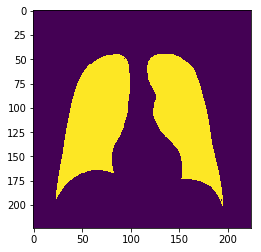

In [49]:
# ground truth
plt.imshow(np.resize(train_label[100,:],(224,224)))

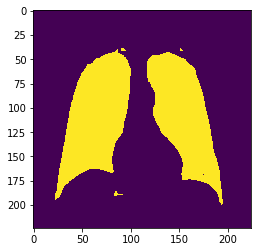

In [53]:
# predicted
plt.imshow(np.resize(g,(224,224)))

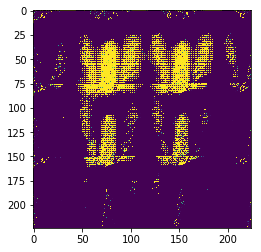

In [40]:
# initial predicted images with epoch=2
plt.imshow(np.resize(p,(224,224)))

## End

In [ ]:
# PLOTS FOR IOU CURVE
# import matplotlib.pyplot as plt
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['iou_coef'])
# plt.plot(history.history['val_iou_coef'])
# plt.title('model iou')
# plt.ylabel('iou')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

['acc', 'loss', 'val_acc', 'val_loss']


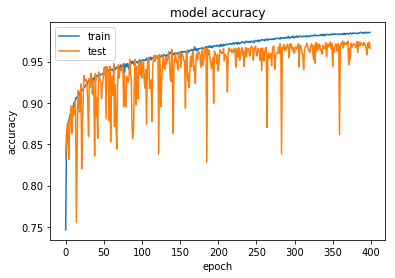

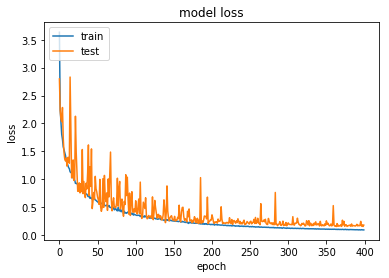

In [27]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model3.save_weights('weights/prop_tiramisu_1_4_BS10_weights_67_12_func_10-e7_decay{}.hdf5'.format(nb_epoch))

['acc', 'loss', 'val_acc', 'val_loss']


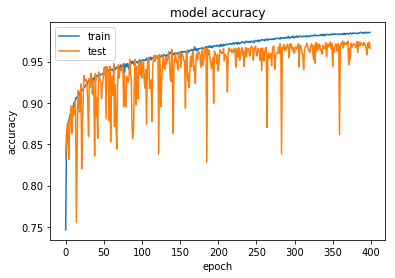

In [30]:
##save plots
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
plt.savefig('Model Accuracy Curve_1_4_BS10.png')
# summarize history for loss


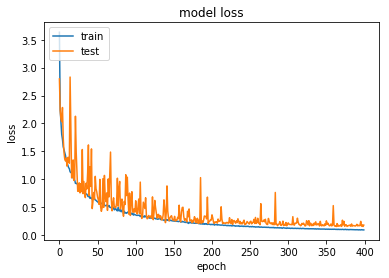

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
plt.savefig('Loss Curve_1_4_BS10.png')

Confusion matrix, without normalization
[[31265  1584]
 [ 6027 11300]]
Normalized confusion matrix
[[0.95 0.05]
 [0.35 0.65]]


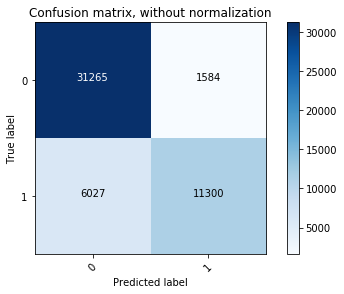

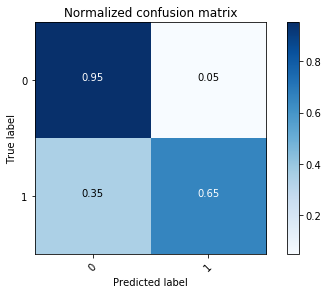

In [86]:
##confusion matrix for diseased sample test
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_label[33,:], g33)
np.set_printoptions(precision=2)
class_names=[0,1]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [87]:
##confusion matrix
p42=model2.predict(np.expand_dims(test_data[42,:],0))
g42 = (p42>=0.5).astype(np.int32)
np.unique(g42)
g42=np.ravel(g42)
g42.shape

(50176,)

Confusion matrix, without normalization
[[38186   255]
 [  222 11513]]
Normalized confusion matrix
[[0.99 0.01]
 [0.02 0.98]]


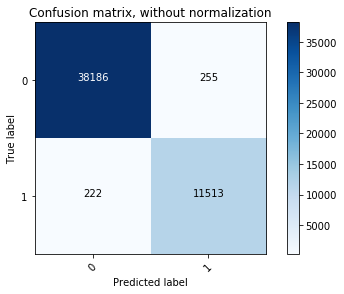

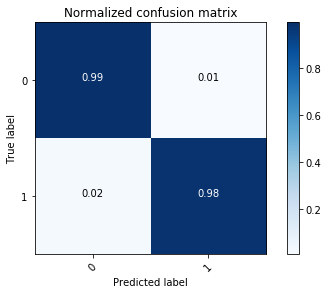

In [88]:
##confusion matrix for non diseased sample - test
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_label[42,:], g42)
np.set_printoptions(precision=2)
class_names=[0,1]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()